In [1]:
import pandas as pd
import numpy as np
!pip install sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses

df= pd.read_csv("Payload_dataset.csv",lineterminator='\n').sample(200000).reset_index(drop=True)
df.head()

Unnamed: 0                                            Payload  label
0        4061        modo=insertar&precio=1632&B1=Pasar+por+caja      0
1      214837  login=61%27%20OR%20%2761%27=%2761&pwd=FrAmE30....      1
2      120782  This movie looked like it was rushed to releas...      0
3       65801  k im2ell4x9o1gvxhzmoi75ecr5hprp3l 52jw5o6vec7m...      1
4       53717   select * from users where id = 1 or ?@ or 1 =...      1

In [5]:
df.shape

(200000, 3)

In [6]:
#just get two col form data expcet unamed
df = df[['Payload', 'label']]

In [7]:
## train test split 80%/20%
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.20,random_state=50,shuffle=True)

train_df.head()

Payload  label
114199  1'  )  )   )  or /*I have bought the DVD of th...      1
18301   id=&version=&csrf_token=7e3ad709a3cfdc4dd17ded...      1
142956  /image/7468?name=%D8%B3%DB%8C%D9%86%DA%A9-10-%...      0
75599   At the beginning of the film we watch May and ...      0
164924                             -3186 or 3867  =  9405      1

In [8]:
train_examples = []
for i in range(len(train_df)):
  row = train_df.iloc[i]
  train_examples.append(InputExample(texts=[row['Payload']], label=row['label']))

We use triplet loss to fine tune the BERT model to produce sentence embeddings that are closer together SQL of the same label, and farther apart for SQL of different labels.

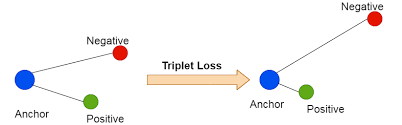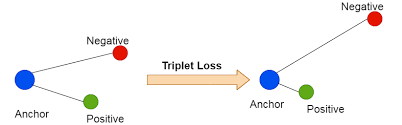

In [9]:
! pip install transformers[torch]


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader, Dataset

# Custom Dataset class to work with InputExample
class CustomDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        return example



# Create a list of InputExample objects
train_examples = []
for i in range(len(train_df)):
    row = train_df.iloc[i]
    train_examples.append(InputExample(texts=[str(row['Payload'])], label=float(row['label'])))

# Create a DataLoader using the custom dataset
train_dataset = CustomDataset(train_examples)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load your SentenceTransformer model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Define the loss function
train_loss = losses.BatchAllTripletLoss(model=model)

# Tune the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=100
)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Save the fine-tuned model
model_save_path = '/Model'  
model.save(model_save_path)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [14]:
test_examples = []
for i in range(len(test_df)):
  row = test_df.iloc[i]
  test_examples.append(InputExample(texts=[row['Payload']], label=row['label']))

In [15]:
import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
# train_df['orig_emb'] = train_df['Payload'].progress_apply(lambda x: orig_model.encode(x, show_progress_bar=False))
train_df['ft_emb'] = train_df['Payload'].progress_apply(lambda x: model.encode(x, show_progress_bar=False))


  0%|          | 0/160000 [00:00<?, ?it/s]

In [16]:
#train_df['orig_emb'] = train_df['orig_emb'].progress_apply(lambda x: x.numpy())
#train_df['ft_emb'] = train_df['ft_emb'].progress_apply(lambda x: x.numpy())

train_df.head()

Payload  label  \
114199  1'  )  )   )  or /*I have bought the DVD of th...      1   
18301   id=&version=&csrf_token=7e3ad709a3cfdc4dd17ded...      1   
142956  /image/7468?name=%D8%B3%DB%8C%D9%86%DA%A9-10-%...      0   
75599   At the beginning of the film we watch May and ...      0   
164924                             -3186 or 3867  =  9405      1   

                                                   ft_emb  
114199  [-0.92400575, -0.9083213, 0.46461526, 0.976874...  
18301   [-0.9865568, -0.9448561, 0.41420597, 1.020998,...  
142956  [-0.48113665, 0.17253219, 0.12436395, -0.64163...  
75599   [-1.0709016, -0.7203959, 0.5604899, -0.6317304...  
164924  [-0.92007077, -0.9686696, 0.50259215, 0.969755...

The default embeddings from the LLM have decent class separation, but there is some overlap between them. Let's see if our finetuned model has better class separation or not.

In [21]:
embeddings = train_df['ft_emb'].apply(lambda x: np.asarray(x))#.to_numpy()
embeddings = np.array(train_df['ft_emb'].values.tolist())
print(embeddings.shape)
#print(embeddings[0])

(160000, 768)


In [22]:
from sklearn.manifold import TSNE
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

# Fit and transform
embeddings2d = tsne.fit_transform(embeddings)

# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['isAttack'] = train_df['label']
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

isAttack           x          y
114199         1  -61.485279  -0.072588
18301          1  -19.983360  64.498878
142956         0  101.517944  25.332138
75599          0   40.574844 -69.977013
164924         1  -42.652130 -79.969154

In [23]:
import plotly.express as px

fig = px.scatter(
    embeddingsdf, x='x', y='y',
    color='isAttack', labels={'color': 'isAttack'},
    title = 'Web Attack finetuned BERT embedding')
fig.show()

The fine tuned model has a much better class separation with its embeddings! Does this generalize to the unseen test set well?

In [24]:
test_df['ft_emb'] = test_df['Payload'].progress_apply(lambda x: model.encode(x, show_progress_bar=False))
test_df.head()

  0%|          | 0/40000 [00:00<?, ?it/s]

Payload  label  \
184216                 1,iif  (  6333  =  1227,1,1/0  )        1   
111680                      paraje antonio de nebrija 39,      0   
7558    What was I thinking when I rented this one? Wh...      0   
108160  This film has great acting, great photography ...      0   
128007  login=61%27%20OR%20%2761%27=%2761&pwd=FrAmE30....      1   

                                                   ft_emb  
184216  [-0.9789398, -0.9607582, 0.4483592, 0.96909535...  
111680  [-0.6570221, 0.21850449, -0.020855548, -0.7209...  
7558    [-0.22844446, 0.1073133, 0.074147604, 0.320679...  
108160  [-0.46615282, -0.18619297, -0.5644744, -0.3180...  
128007  [-0.9847608, -0.96034145, 0.42462635, 0.978287...

In [25]:
embeddings = test_df['ft_emb'].apply(lambda x: np.asarray(x))#.to_numpy()
embeddings = np.array(test_df['ft_emb'].values.tolist())
print(embeddings.shape)
#print(embeddings[0])

(40000, 768)


In [26]:
from sklearn.manifold import TSNE
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

# Fit and transform
embeddings2d = tsne.fit_transform(embeddings)

# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['isAttack'] = test_df['label']
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

isAttack          x          y
184216         1 -51.444157 -39.463715
111680         0  67.945366  39.449387
7558           0  21.623278 -41.624386
108160         0  36.400246 -78.753891
128007         1 -89.295418 -32.015545

In [27]:
import plotly.express as px

fig = px.scatter(
    embeddingsdf, x='x', y='y',
    color='isAttack', labels={'color': 'isAttack'},
    title = '[TEST]Webattack data Embedding')
fig.show()

Yes! The finetuned model has good class separation with embedding the SQL queries for queries it was not trained on. We can likely create a classifier on these embeddings and achieve good accuracy.

# Classifier

In [28]:
train_df.head()

Payload  label  \
114199  1'  )  )   )  or /*I have bought the DVD of th...      1   
18301   id=&version=&csrf_token=7e3ad709a3cfdc4dd17ded...      1   
142956  /image/7468?name=%D8%B3%DB%8C%D9%86%DA%A9-10-%...      0   
75599   At the beginning of the film we watch May and ...      0   
164924                             -3186 or 3867  =  9405      1   

                                                   ft_emb  
114199  [-0.92400575, -0.9083213, 0.46461526, 0.976874...  
18301   [-0.9865568, -0.9448561, 0.41420597, 1.020998,...  
142956  [-0.48113665, 0.17253219, 0.12436395, -0.64163...  
75599   [-1.0709016, -0.7203959, 0.5604899, -0.6317304...  
164924  [-0.92007077, -0.9686696, 0.50259215, 0.969755...

In [29]:
test_df.head()

Payload  label  \
184216                 1,iif  (  6333  =  1227,1,1/0  )        1   
111680                      paraje antonio de nebrija 39,      0   
7558    What was I thinking when I rented this one? Wh...      0   
108160  This film has great acting, great photography ...      0   
128007  login=61%27%20OR%20%2761%27=%2761&pwd=FrAmE30....      1   

                                                   ft_emb  
184216  [-0.9789398, -0.9607582, 0.4483592, 0.96909535...  
111680  [-0.6570221, 0.21850449, -0.020855548, -0.7209...  
7558    [-0.22844446, 0.1073133, 0.074147604, 0.320679...  
108160  [-0.46615282, -0.18619297, -0.5644744, -0.3180...  
128007  [-0.9847608, -0.96034145, 0.42462635, 0.978287...

In [30]:
X_train = train_df['ft_emb'].tolist()
y_train = train_df['label'].tolist()

X_test = test_df['ft_emb'].tolist()
y_test = test_df['label'].tolist()

In [31]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [32]:
from sklearn import metrics
predicted = LR.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression F1 Score: ", metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.989925
Logistic Regression Precision: 0.9955596760027325
Logistic Regression Recall: 0.9849384503982621
Logistic Regression F1 Score:  0.99022058288238


<Axes: >

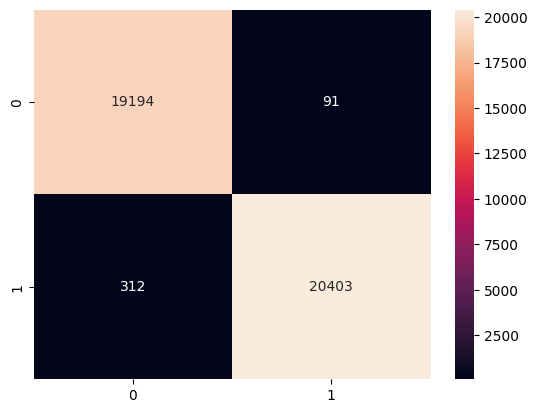

In [33]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g')

<Axes: >

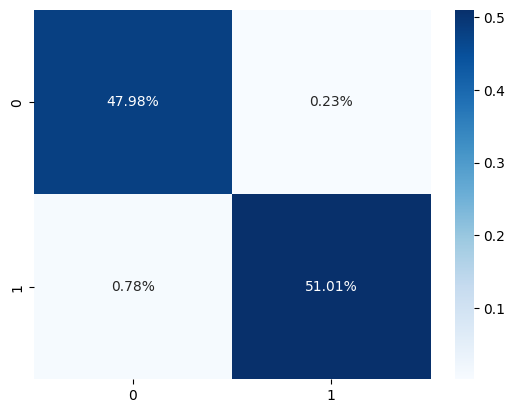

In [34]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

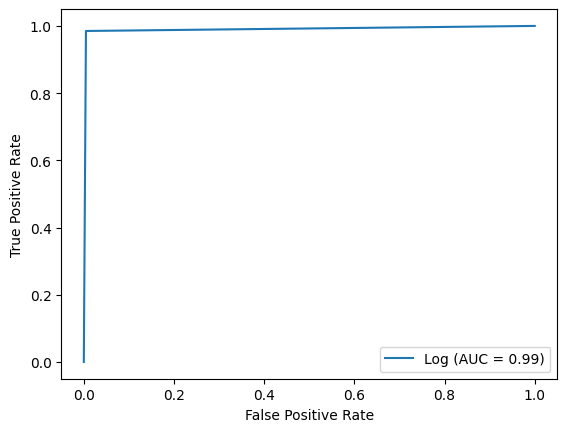

In [35]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Log')
display.plot()
plt.show()

In [36]:
firstone=X_test[0:4]
yone=y_test[0:4]
yone

[1, 0, 0, 0]

In [37]:
from joblib import dump

# Assuming LR is your trained LogisticRegression model
dump(LR, 'logistic_regression_model.joblib')


['logistic_regression_model.joblib']

In [38]:
from joblib import load

# Load the saved model
LR2 = load('logistic_regression_model.joblib')


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming X_test and y_test are your test data features and labels
predicted = LR2.predict(firstone)
print(predicted)
# # Calculate metrics
# accuracy = accuracy_score(y_test, predicted)
# precision = precision_score(y_test, predicted)
# recall = recall_score(y_test, predicted)
# f1 = f1_score(y_test, predicted)

# print("Logistic Regression Metrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Confusion Matrix
# cf_matrix = confusion_matrix(y_test, predicted)
# print("\nConfusion Matrix:")
# print(cf_matrix)


[1 0 0 0]


In [ ]:
# pip install gradio


  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/7b/5d/0e1c1a73a01280f2ea83bca8cbda441403d923aaa4d92c36b3d8f8fb69dd/gradio-4.39.0-py3-none-any.whl.metadata
  Obtaining dependency information for fastapi from https://files.pythonhosted.org/packages/a4/d4/eb78f7c2648a3585095623f207d7e4b85a1be30347e01e0fdcd1d7d167a9/fastapi-0.111.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for gradio-client==1.1.1 from https://files.pythonhosted.org/packages/06/b3/a9e72cd3a982f2ed5a4ec5fc7b5ef21a01d746e03e33b7ee800621b91d63/gradio_client-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for httpx>=0.24.1 from https://files.pythonhosted.org/packages/41/7b/ddacf6dcebb42466abd03f368782142baa82e08fc0c1f8eaa05b4bae87d5/httpx-0.27.0-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources<7.0,>=1.3 from htt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.8.2 which is incompatible.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


In [ ]:
# import gradio as gr
# import numpy as np
# from sentence_transformers import SentenceTransformer
# import joblib

# # Load the fine-tuned Sentence Transformer model
# model_path = 'C:\\Users\\User\\OneDrive - Ministere de l\'Enseignement Superieur et de la Recherche Scientifique\\Bureau\\test\\Injection\\Model'
# model = SentenceTransformer(model_path)

# # Load the trained Logistic Regression classifier
# classifier_path = 'logistic_regression_model.joblib'
# classifier = joblib.load(classifier_path)

# def predict_web_attack(payload):
#     # Encode the input payload using the fine-tuned model
#     embedding = model.encode(payload, show_progress_bar=False)
#     # Predict the class using the classifier
#     prediction = classifier.predict([embedding])
#     # Convert numerical prediction to a readable label (adjust as per your label encoding)
#     label = 'Attack' if prediction[0] == 1 else 'Normal'
#     return label

# # Create the Gradio interface
# interface = gr.Interface(
#     fn=predict_web_attack,
#     inputs="text",
#     outputs="text",
#     title="Web Attack Detection",
#     description="Enter a payload to predict if it's an attack or normal traffic.",
# )

# # Launch the interface
# if __name__ == "__main__":
#     interface.launch()


You try to use a model that was created with version 3.0.1, however, your version is 2.4.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
